In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Master Thesis/data
%ls

import glob
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
from tqdm.notebook import tqdm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

from scipy.stats import pearsonr, spearmanr, kendalltau
from statsmodels.tools.tools import pinv_extended

instaCompanies = glob.glob('./ProcessedComps/*.csv')
compList = []
for i in instaCompanies:
  compList.append(i[17:-9])

compList.sort()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master Thesis/data
 aggregatedForAllComps_esg.csv                marketCap_processedFinal.csv
 aggregatedForAllComps_esgRefinitiv.csv       plotAcf_ClimateBert_M.png
 aggregatedForAllComps_RepRiskRating.csv      plotAcf_TwitterBert_M.png
 aggregatedForAllComps_RepRiskRRI.csv         predCmmtsAgg_M.csv
 aggregatedForAllControls_esg.csv             predCmmtsAgg_Y.csv
 aggregatedForAllControls_esgRefinitiv.csv    ProcessedComps/
 aggregatedForAllControls_RepRiskRating.csv   Results/
 aggregatedForAllControls_RepRiskRRI.csv      ResultsTest/
 allControls.csv                              sp500Monthlyrets.csv
 controls.csv                                'sp500Sectors (1).csv'
 ESG/                                         testing.csv
 marketCap.csv                               'To be Checked but already processed'/


In [ ]:
def getResults(comp,resultName, dropCols):
  path = './Results/%s'%comp
  df = pd.read_csv(path + '/%s.csv'%resultName)
  df['PostDate'] = pd.to_datetime(df['PostDate']).dt.strftime('%Y-%m-%d')
  df['PostDate'] = pd.to_datetime(df['PostDate'])
  df.set_index(['PostDate'], inplace = True)

  df.drop(columns = dropCols, inplace = True)

  if 'Unnamed: 0.1' in df.columns:
    df.drop(columns = ['Unnamed: 0.1'], inplace = True)

  if 'Unnamed: 0' in df.columns:
    df.drop(columns = ['Unnamed: 0'], inplace = True)

  df.sort_index(inplace = True)
  return df

def corr(df):
  '''

  function that calculates the correlation between NLP sentiment methods

  '''
  pd.options.display.float_format = '{:.5f}'.format
  pearson = pd.DataFrame([pearsonr(df['sentiment'].values,df['sentimentGen'].values)]).T
  spearman = pd.DataFrame([spearmanr(df['sentiment'].values,df['sentimentGen'].values)]).T
  kendall = pd.DataFrame([kendalltau(df['sentiment'].values,df['sentimentGen'].values)]).T
  result = pd.concat([pearson,spearman,kendall], axis=1)
  result.columns = ['PearsonR','Spearman','Kendall']
  return result

def getStats(df,stat):
  stats = pd.DataFrame(df.mean()).T
  stats = pd.concat([stats,pd.DataFrame(df[df.statistic==df.statistic.min()])])
  stats = pd.concat([stats,pd.DataFrame(df[df.statistic==df.statistic.max()])])
  stats.index = ['mean', 'min', 'max']
  stats.columns = ['stat-%s'%stat,'pvalue-%s'%stat]
  return stats

def removeInf(df):
  mask = (df == -np.inf).any(axis=1)
  return df[~mask]

In [ ]:
sentimentCorr = {}
userSent = {}
companyClass = {}
for c in tqdm(compList):
  companyClass[c] = getResults(c,'predDescript', ['Description', 'PostsComments'])
  userSent[c] = getResults(c,'predCmmtsMean_neutralized', ['Description'])
  sentimentCorr[c] = corr(userSent[c])

  0%|          | 0/185 [00:00<?, ?it/s]

Returns the average, min and max correlations between NLP methods

In [ ]:
pear = pd.DataFrame()
spear = pd.DataFrame()
kend = pd.DataFrame()

for c in tqdm(compList):
  corr = sentimentCorr[c]

  pear = pd.concat([pear,corr[['PearsonR']].T])
  spear = pd.concat([spear,corr[['Spearman']].T])
  kend = pd.concat([kend,corr[['Kendall']].T])

pear.index = compList
spear.index = compList
kend.index = compList

stats = pd.concat([getStats(pear,'pearson'),getStats(spear,'spearman'),getStats(kend,'kendall')], axis = 1)
stats

  0%|          | 0/185 [00:00<?, ?it/s]

,stat-pearson,pvalue-pearson,stat-spearman,pvalue-spearman,stat-kendall,pvalue-kendall
mean,0.53752,0.00010,0.53984,0.00013,0.45439,0.00009
min,0.09860,0.01725,0.09809,0.01783,0.08849,0.01269
max,0.85456,0.00000,0.86926,0.00000,0.85721,0.00000


Min correlation goes to IDEXX LABORATORIES INC. Potential reason after investigation is that they have a lot of posts containing ONLY emojis.

In [ ]:
minStats = [pear[pear['statistic']==pear['statistic'].min()].index.tolist()[0], spear[spear['statistic']==spear['statistic'].min()].index.tolist()[0], kend[kend['statistic']==kend['statistic'].min()].index.tolist()[0]]
minStats

['IDEXX LABORATORIES INC', 'IDEXX LABORATORIES INC', 'IDEXX LABORATORIES INC']

#ESG Ratings AutoCorrelation

Autocorrelation for ESG ratings

In [ ]:
allEsg = {}
provs = ['RepRiskRating', 'RepRiskRRI', 'esg', 'esgRefinitiv']
dates = {'RepRiskRating':'date', 'RepRiskRRI':'date', 'esg':'Start Date', 'esgRefinitiv':'Post Date'}
diffCols = {'RepRiskRating':['ratingchange'], 'RepRiskRRI':['current_rriDiff'], 'esg':['SocialDiff',	'GovDiff',	'EnvDiff',	'ESGDiff'], 'esgRefinitiv':['ESG Score',	'ESG Controversies Score',	'ESG Combined Score',	'Environmental Pillar Score','Social Pillar Score',	'Governance Pillar Score']}
dateFormat = {'RepRiskRating':'%Y-%m-%d', 'RepRiskRRI':'%Y-%m-%d', 'esg':'%d.%m.%Y', 'esgRefinitiv':'%d.%m.%Y'}

for p in tqdm(provs):
  dateCol = dates[p]
  diffCol = diffCols[p]
  dateForm = dateFormat[p]

  df = pd.DataFrame()

  for c in compList:
    path = './Results/%s'%c
    try:
      if p != 'esgRefinitiv':
        esg = pd.read_csv(path+'/%s.csv'%p)[[dateCol]+diffCol].dropna(axis=1)
        esg[dateCol] = pd.to_datetime(esg[dateCol], format = dateForm)
        esg.set_index(dateCol,inplace=True)
        esgDiffDf = esg[(esg!=0).any(axis=1)]

      else:
          esg = pd.read_csv(path+'/%s.csv'%p)[diffCol]
          esg.index = ['31.12.2021','31.12.2020','31.12.2019','31.12.2018','31.12.2017','31.12.2016']
          esg.index = pd.to_datetime(esg.index, format = dateForm)
          esgDiffDf = esg.sort_index().diff()
          esgDiffDf.rename_axis(dateCol, inplace = True)
    except:
      continue

    df = pd.concat([df,esgDiffDf])
  df.dropna(how = 'all', inplace = True)
  if p =='esgRefinitiv':
    allEsg[p] = df.reset_index().rename(columns = {dateCol :'PostDate'}).groupby(by='PostDate').mean().sort_index()

  else:
    allEsg[p] = df.reset_index().rename(columns = {dateCol :'PostDate'}).set_index('PostDate').resample('M').mean()


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
def autocorr(company, name = None, provider = None,agg = 'M'):
  fig, ax = plt.subplots()
  plot_acf(company, ax = ax, lags=min(15,len(company)-1), alpha=0.05, title = provider);
  plt.show()
'''  if name == None:
    plt.savefig('./plotAcf_%s_%s.png'%(provider, agg), format = 'png')

  else:
    plt.savefig('./Results/%s/plotAcf_%s_%s.png'%(name,provider,agg), format = 'png')'''



In [ ]:
autocorr(allEsg['esg']['ESGDiff'].dropna(), provider = 'Bloomberg ESG Score')
autocorr(allEsg['esgRefinitiv']['ESG Score'].dropna(), provider = 'Refinitiv ESG Score')
autocorr(allEsg['RepRiskRating']['ratingchange'].dropna(), provider = 'RRR change')
autocorr(allEsg['RepRiskRRI']['current_rriDiff'].dropna(), provider = 'RRI change')

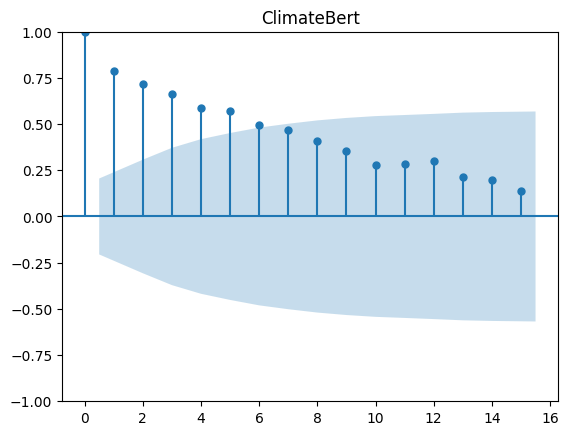

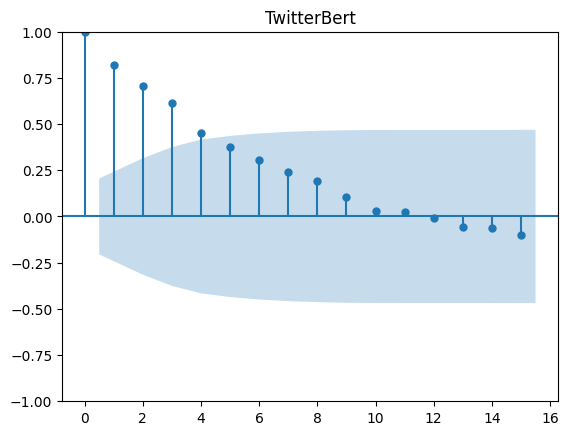

In [ ]:
sentAC = pd.read_csv('./predCmmtsAgg_M.csv')['sentiment']
sentGenAC = pd.read_csv('./predCmmtsAgg_M.csv')['sentimentGen']

autocorr(sentAC, name = None, provider = 'ClimateBert', agg = 'M')
autocorr(sentGenAC, name = None, provider = 'TwitterBert', agg = 'M')

bbgEmpty, refEmpty, rriEmpty: All companies whose earliest post occurs after the last change in ESG Rating

noRef, norri = all companies that don't have data for RRI and Refinitiv

In [ ]:
bbgEmpty = []
refEmpty = []
rriEmpty = []

noRef = []
norri = []

rriCmp = {}
bbgCmp = {}
refCmp = {}
ratCmp = {}
for c in tqdm(compList):

  try:
    rriCmp[c] = pd.read_csv('./Results/%s/predCmmtsAgg_rri.csv'%c)
    ratCmp[c] = pd.read_csv('./Results/%s/predCmmtsAgg_rrating.csv'%c)
    if rriCmp[c].isna().all().all():
      rriEmpty.append(c)
  except:
    norri.append(c)

  bbgCmp[c] = pd.read_csv('./Results/%s/predCmmtsAgg_bbg.csv'%c)

  try:
    refCmp[c] = pd.read_csv('./Results/%s/predCmmtsAgg_refi.csv'%c)
    if refCmp[c].isna().all().all():
      refEmpty.append(c)

  except:
    noRef.append(c)

#  if rriCmp[c].isna().all().all():
#    rriEmpty.append(c)

  if bbgCmp[c].isna().all().all():
    bbgEmpty.append(c)

#  if refCmp[c].isna().all().all():
#    refEmpty.append(c)

  0%|          | 0/185 [00:00<?, ?it/s]

In [ ]:
norri

['ANSYS INC',
 'GE HEALTHCARE TECHNOLOGY',
 'JACOBS SOLUTIONS INC',
 'SEAGATE TECHNOLOGY HOLDINGS',
 'SOLAREDGE TECHNOLOGIES INC']

#Dataset details

Get total number of posts & comments collected

In [ ]:
allPosts = []
allComments = []
allCommentsPerPost = []

for c in tqdm(compList):
  df = companyClass[c]
  allPosts.append(df.PostIndex.max())
  allComments.append(len(df))
  allCommentsPerPost.append(df.groupby('PostIndex').count().env.tolist())

allCommentsPerPostFlat = [item for sublist in allCommentsPerPost for item in sublist]

  0%|          | 0/185 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame()
for c in tqdm(compList):
  df = pd.concat([df,companyClass[c].drop_duplicates(subset=['PostIndex'])])

  0%|          | 0/185 [00:00<?, ?it/s]

Number of posts with no ESG Categorization

In [ ]:
none = df[['ESGFin']]
none2 = df[['env','soc','gov']]

print('Num of posts not categorized by FinBERT: %s' %len(none[none.isna().values]))
print('Num of posts not categorized by ClimateBERT: %s' %len(none2[(none2 == 0).all(axis=1)]))

Num of posts not categorized by FinBERT: 23595
Num of posts not categorized by ClimateBERT: 63529


In [ ]:
totalPosts = sum(allPosts)
totalComments = sum(allComments)
print('Total number of posts is: %s' %totalPosts)
print('Total number of comments is: %s' %totalComments)
print('Average number of comments per post is: %s' %np.mean(allCommentsPerPostFlat))

Total number of posts is: 189524
Total number of comments is: 982906
Average number of comments per post is: 5.188180584953365


In [ ]:
postClasses = pd.DataFrame()

for c in compList:
  df = companyClass[c].drop_duplicates(subset=['PostIndex'])
  #res = df[['env','soc','gov']].sum().values + [df['ESGFin'].tolist().count('E'), df['ESGFin'].tolist().count('S'), df['ESGFin'].tolist().count('G')]
  res = [df[['env','soc','gov']].sum().tolist() + [df['ESGFin'].tolist().count('E'), df['ESGFin'].tolist().count('S'), df['ESGFin'].tolist().count('G')]]
  postClasses = pd.concat([postClasses, pd.DataFrame(res)])

postClasses.index = compList
postClasses.columns = ['env','soc','gov', 'E', 'S', 'G']
postClasses = pd.concat([postClasses, pd.DataFrame([postClasses.sum()], index = ['Total'])])
postClasses

,env,soc,gov,E,S,G
ACTIVISION BLIZZARD INC,14,134,0,12,139,0
ADOBE INC,415,1492,0,500,1642,3
ADVANCE AUTO PARTS INC,206,722,0,215,1120,0
ADVANCED MICRO DEVICES,27,62,1,32,104,0
ALASKA AIR GROUP INC,602,1291,0,314,1994,0
...,...,...,...,...,...,...
WESTERN DIGITAL CORP,115,247,0,208,324,1
WHIRLPOOL CORP,133,750,8,91,823,0
WW GRAINGER INC,422,524,6,310,578,2
WYNN RESORTS LTD,115,871,3,190,1040,0


In [ ]:
sectors = pd.read_csv('./sp500Sectors (1).csv').drop(columns = ['Name','SectoID'])
bbgNames = pd.read_csv('./ESG/SP500_Names.csv')
names = pd.DataFrame(np.vstack( [ bbgNames.columns, bbgNames ] ), columns = ['Ticker', 'Name'])

sectorsBBG = pd.merge(names, sectors,left_on = 'Ticker', right_on = 'Ticker')

sector = []

for c in postClasses.index[:-1]:
  sector.append(sectorsBBG[sectorsBBG['Name']==c]['Sector'].tolist()[0])

sectorInfo = postClasses.iloc[:-1,:].copy()
sectorInfo['Sector'] = sector

allsectorInfo = pd.merge(sectorInfo, pd.DataFrame(allPosts, index = compList, columns = ['Total Posts']), left_index = True, right_index = True)

totalPostsBySector =allsectorInfo.groupby('Sector').sum().sort_values('Total Posts')
totalPostsBySector

,env,soc,gov,E,S,G,Total Posts
Sector,,,,,,,
Energy,1117,1047,14,624,1174,0,2163
Real Estate,427,1173,4,798,1627,1,2864
Utilities,2374,2019,7,1786,2388,8,4367
Materials,2893,5542,82,3111,4513,10,8408
Health Care,567,6807,26,638,7735,5,8852
Communication Services,1066,9007,20,764,11695,6,14105
Financials,1971,11051,121,1176,13782,40,16401
Information Technology,3618,12487,94,3903,18156,24,25355
Consumer Staples,6205,20504,65,6835,21125,16,30179


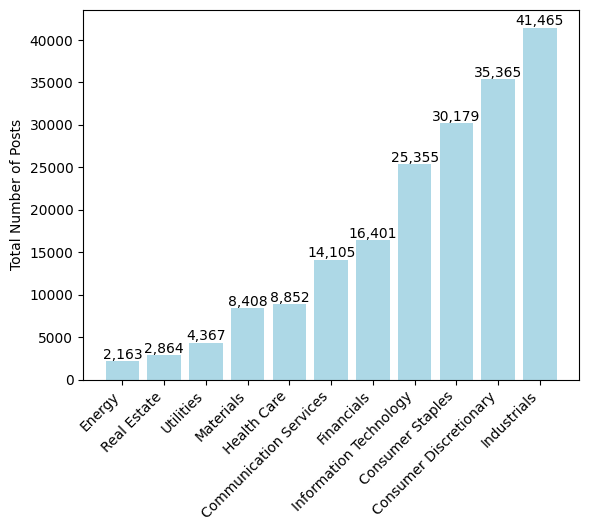

In [ ]:
# Data for the bars
categories = totalPostsBySector.index
values =  totalPostsBySector['Total Posts'].tolist()

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the bars
colors = ['#ADD8E6']
bars = ax.bar(categories, values, color=colors)

for bar, value in zip(bars, values):
    if value is not None:
        formatted_value = f'{value:,}'  # Add a comma as a thousands separator
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+300, formatted_value, ha='center')


# Set labels for the bars
plt.xticks(rotation=45, ha="right")
ax.set_ylabel('Total Number of Posts')

# Display the plot
plt.show()


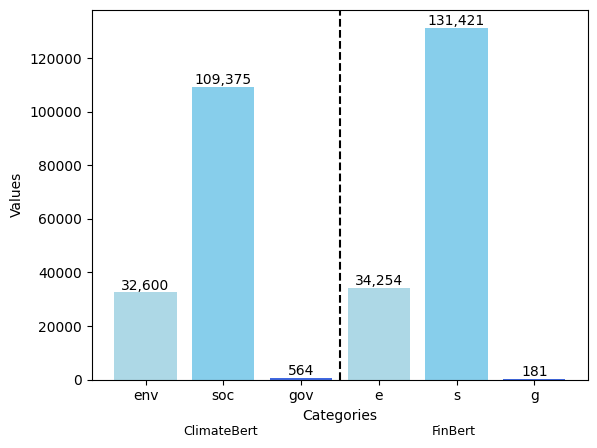

In [ ]:
# Data for the bars
categories = ['env', 'soc', 'gov', 'e', 's', 'g']
values =  postClasses.loc['Total'].tolist()

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the bars
colors = ['#ADD8E6', '#87CEEB', '#4169E1']
bars = ax.bar(categories, values, color=colors)

# Set labels for the bars
ax.set_xlabel('Categories')
ax.set_ylabel('Values')

# Add a vertical line after the 'gov' bar
ax.axvline(x=2.5, color='black', linestyle='--', linewidth=1.5)

# Add numbers on top of the bars
for bar, value in zip(bars, values):
    if value is not None:
        formatted_value = f'{value:,}'  # Add a comma as a thousands separator
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1000, formatted_value, ha='center')


ax.annotate('ClimateBert', xy=(0.26, -0.15), xycoords='axes fraction', fontsize=9, ha='center')
ax.annotate('FinBert', xy=(0.73, -0.15), xycoords='axes fraction', fontsize=9, ha='center')

# Display the plot
plt.show()


In [ ]:
monthlySentiments = pd.read_csv('./predCmmtsAgg_M.csv')
monthlySentiments['PostDate'] = pd.to_datetime(monthlySentiments['PostDate'])
monthlySentiments.set_index('PostDate', inplace = True)
monthlySentiments = monthlySentiments[(monthlySentiments.index >= pd.Timestamp('2016-01-31')) & (monthlySentiments.index<= pd.Timestamp('2023-06-30'))]


results = pd.DataFrame()

for c in compList:
  results = pd.concat([results, userSent[c]])

sents = results.sort_index()
sents = sents[(sents.index >= pd.Timestamp('2016-01-31')) & (sents.index<= pd.Timestamp('2023-06-30'))]
sentsFinal = sents[['sentiment','sentimentGen']].groupby(level = 0).mean()


In [ ]:
sprets = pd.read_csv('./sp500Monthlyrets.csv').iloc[:,:2]
sprets.caldt = pd.to_datetime(sprets.caldt)

monthly2022 = monthlySentiments[monthlySentiments.index<=pd.Timestamp('2022-12-31')].reset_index()
sentRet = pd.merge(monthly2022,sprets, left_index =True, right_index = True).drop(columns = ['caldt'])
sentRetDiff = sentRet.diff()[1:]
sentRet

,PostDate,sentiment,sentimentGen,vwretx
0,2016-01-31,0.11942,0.22043,-0.05025
1,2016-02-29,0.09563,0.21306,-0.00446
2,2016-03-31,0.14737,0.24173,0.06515
3,2016-04-30,0.12594,0.22896,0.00258
4,2016-05-31,0.13290,0.24296,0.01589
...,...,...,...,...
79,2022-08-31,0.12753,0.33547,-0.04205
80,2022-09-30,0.10406,0.31317,-0.09288
81,2022-10-31,0.12367,0.33333,0.07920
82,2022-11-30,0.14411,0.35105,0.05216


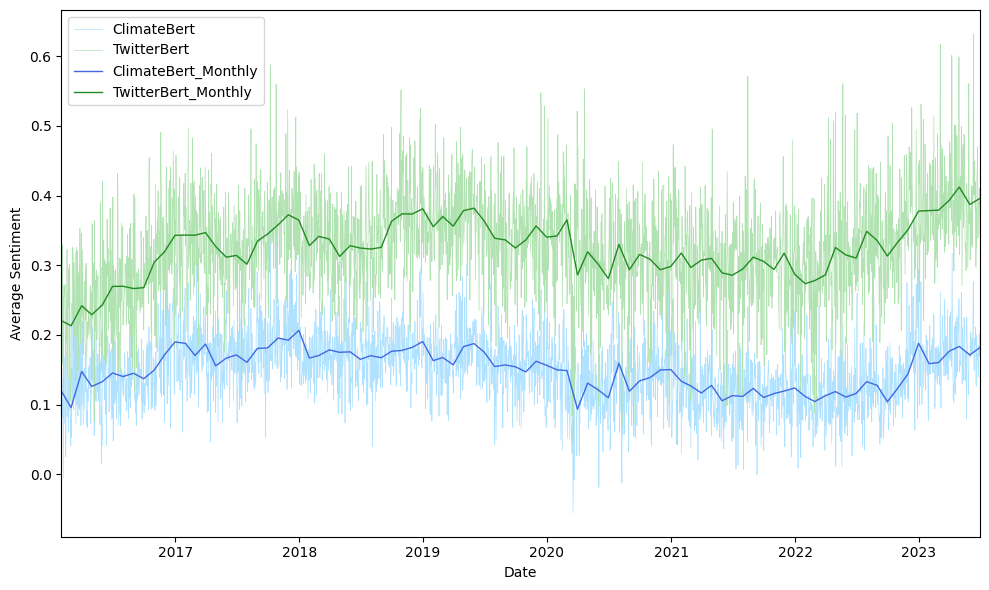

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sentsFinal.index, sentsFinal['sentiment'], label='ClimateBert', linewidth = 0.5, color ='#B0E2FF' )
plt.plot(sentsFinal.index, sentsFinal['sentimentGen'], label='TwitterBert', linewidth = 0.5, color =  '#B1E2B1')
plt.plot(monthlySentiments.index, monthlySentiments['sentiment'], label='ClimateBert_Monthly', linewidth = 1, color ='#4169E1' )
plt.plot(monthlySentiments.index, monthlySentiments['sentimentGen'], label='TwitterBert_Monthly', linewidth = 1, color =  '#228B22')


plt.xlim(pd.Timestamp('2016-01-31'), pd.Timestamp('2023-06-30'))
# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

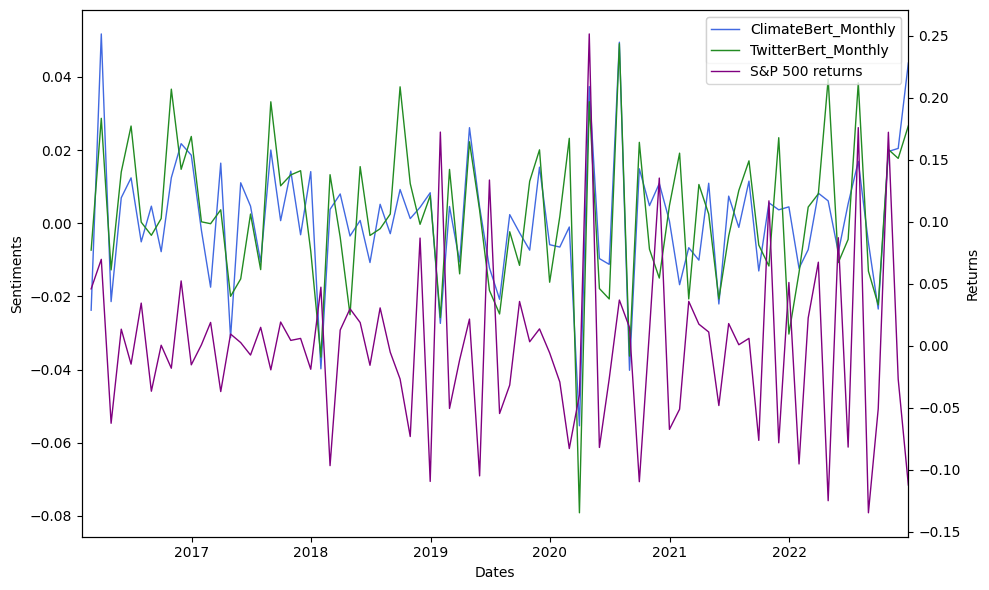

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(sentRet['PostDate'][1:], sentRetDiff['sentiment'], label='ClimateBert_Monthly', linewidth = 1, color ='#4169E1' )
ax1.plot(sentRet['PostDate'][1:], sentRetDiff['sentimentGen'], label='TwitterBert_Monthly', linewidth = 1, color =  '#228B22')
ax1.set_xlim(pd.Timestamp('2016-01-31'), pd.Timestamp('2022-12-31'))
ax1.set_xlabel('Dates')
ax1.set_ylabel('Sentiments')
ax1.tick_params(axis='y')
plt.legend()

ax2 = ax1.twinx()
ax2.plot(sentRet['PostDate'][1:], sentRetDiff['vwretx'], label='S&P 500 returns', linewidth = 1, color =  'purple')
ax2.set_ylabel('Returns')
ax2.tick_params(axis='y')


# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
monthly2022 = monthlySentiments[monthlySentiments.index<=pd.Timestamp('2022-12-31')].reset_index()
sentRet = pd.merge(monthly2022,sprets, left_index =True, right_index = True).drop(columns = ['caldt'])
sentRetDiff = sentRet.diff()[1:]

In [ ]:
pearsonr(sentRet['sentiment'],sentRet['sentimentGen'])

PearsonRResult(statistic=0.6852433164093413, pvalue=6.491485867435296e-13)

In [ ]:
spearmanr(sentRetDiff['sentiment'][1:],sentRetDiff['vwretx'][:-1])

PearsonRResult(statistic=0.09349847593556926, pvalue=0.4034367259710751)

Mean, variance of sentiments

In [ ]:
print(pd.concat([pd.DataFrame(sentsFinal.mean()).T, pd.DataFrame(sentsFinal.std()).T]))
print(np.corrcoef(sentRetDiff['sentimentGen'][1:],sentRetDiff['vwretx'][:-1]))

Match industry to company

In [ ]:
industries = pd.read_csv('./sp500Sectors (1).csv').set_index('Ticker')
n = pd.read_csv('./ESG/SP500_Names.csv')
names = pd.DataFrame(np.vstack([n.columns, n]), columns = ['Ticker', 'Name']).set_index('Ticker')
namesSector = pd.merge(industries[['Sector']], names, left_index = True, right_index = True)
#namesSector.to_csv('./ESG/companySectors.csv')

In [ ]:
compListSectors = namesSector[namesSector.Name.isin(compList)]

Pie chart of sectors

Text(0.5, 1.0, 'Sector Distribution')

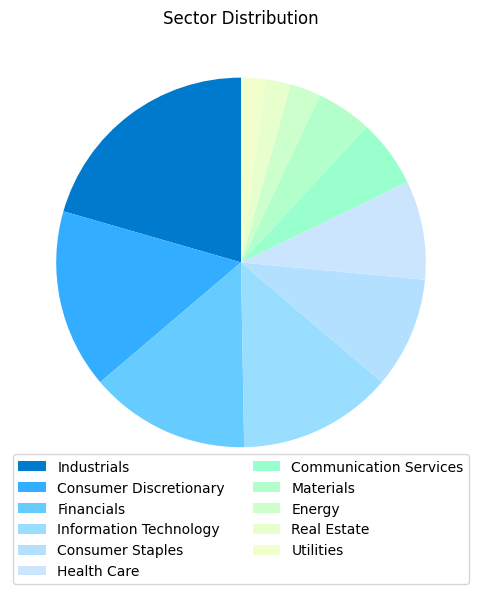

In [ ]:
valueCounts = compListSectors['Sector'].value_counts()

cs = ['#007acc', '#33adff', '#66ccff', '#99ddff', '#b3e0ff', '#cce5ff', '#99ffcc', '#b3ffcc', '#ccffcc', '#e6ffcc', '#f0ffcc']

#plt.figure(figsize=(6, 6))
#plt.pie(valueCounts , rotatelabels = 45, labels=valueCounts.index, colors = cs,startangle=90, pctdistance = 0.9)
#plt.title('Sector Distribution')


fig, ax = plt.subplots(figsize=(6, 6))
wedges, labels = ax.pie(valueCounts, colors=cs, startangle=90, pctdistance=0.85)

# Place the legend-like labels below the pie chart
legend_labels = valueCounts.index
ax.legend(wedges, legend_labels, loc="upper center", bbox_to_anchor=(0.5, 0.1), ncol=2)

ax.set_title('Sector Distribution')

In [ ]:
df = pd.read_csv('./aggregatedForAllControls_esg.csv')
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
bm,64.00000,0.35000,0.05000,0.30000,0.32000,0.34000,0.38000,0.49000
pe_exi,64.00000,24.37000,6.99000,10.18000,19.28000,24.86000,29.19000,41.77000
roa,64.00000,0.14000,0.01000,0.12000,0.14000,0.15000,0.15000,0.15000
debt_assets,64.00000,0.73000,0.01000,0.72000,0.73000,0.73000,0.74000,0.74000
curr_ratio,64.00000,1.55000,0.07000,1.42000,1.49000,1.55000,1.60000,1.65000
MKTC,64.00000,17.57000,0.19000,17.26000,17.43000,17.51000,17.70000,17.90000
sentiment,64.00000,0.14000,0.03000,0.10000,0.12000,0.15000,0.16000,0.22000
sentimentGen,64.00000,0.33000,0.03000,0.25000,0.30000,0.32000,0.35000,0.43000
SocialDiff,57.00000,0.35000,0.64000,-1.20000,0.00000,0.17000,0.53000,2.86000
GovDiff,64.00000,0.06000,0.25000,-0.64000,-0.08000,0.04000,0.15000,0.84000


#Regression w/ Controls
---

In [ ]:
def mergePrior(dates, df):

  ctls = pd.DataFrame(columns = df.columns)

  for d in dates:
    if d.month == 1:
      year = d.year - 1
      month = 12

    else:
      month = d.month - 1
      year = d.year

    ctls = pd.concat([ctls, df.loc['%s-%s'%(year,month)]])

  return ctls


def controlsAndDiffs(comp, provider):

  if provider == 'rri' or provider =='rrating':
    ctls = pd.read_csv('./Results/%s/predCmmtsAgg_%sControlledv3.csv'%(comp, provider))
    ctls['Unnamed: 0'] = pd.to_datetime(ctls['Unnamed: 0'])
    ctls.set_index('Unnamed: 0', inplace = True)
    return ctls

  else:

    try:
      ctls = pd.read_csv('./Results/%s/controls.csv'%(comp))[['public_date', 'bm','pe_exi',	'roa',	'debt_assets'	,'curr_ratio', 'MKTC']]

    except:
      ctls = pd.read_csv('./Results/%s/controls.csv'%(comp))[['Unnamed: 0',	'bm','pe_exi',	'roa',	'debt_assets'	,'curr_ratio', 'MKTC']].rename(columns = {'Unnamed: 0':'public_date'})

    ctls['public_date'] = pd.to_datetime(ctls['public_date'])
    ctls.set_index('public_date', inplace = True)

    diff = pd.read_csv('./Results/%s/predCmmtsAgg_%s.csv'%(comp, provider))
    diff['Unnamed: 0'] = pd.to_datetime(diff['Unnamed: 0'])

    try:
      df = pd.merge(diff, mergePrior(diff['Unnamed: 0'], ctls).reset_index(), left_index = True, right_index = True)
      df.set_index('Unnamed: 0', inplace = True)

      return df

    except:
      return comp

def getRegressionMetrics():

  metrics = {'rrating':['ratingchange'],'rri':['current_rriDiff'],'bbg':['SocialDiff','GovDiff',	'EnvDiff',	'ESGDiff'], 'refi':['ESG Score','ESG Controversies Score',	'ESG Combined Score',	'Environmental Pillar Score','Social Pillar Score',	'Governance Pillar Score']}
  statCols = {}
  for k,v in metrics.items():
    cols = []
    for s in v:
      cols.append([s + '_coef', s + '_Reg', s + '_Pval'])
    statCols[k] = [item for sublist in cols for item in sublist]

  return statCols

def getRegressionResultsControls(df,col, sentType, ctls = ['roa']):


  if sentType == 'cb':
    filteredDf = df[[col, 'sentiment'] + ctls].dropna()
    indep = ['sentiment']+ctls

  else:
    filteredDf = df[[col, 'sentimentGen'] + ctls].dropna()
    indep = ['sentimentGen']+ctls

  model =  sm.OLS(filteredDf[col].values,sm.add_constant(filteredDf[indep].values))

  clf = model.fit_regularized(method='elastic_net', alpha=0, L1_wt=0)

  pinv_wexog,_ = pinv_extended(model.wexog)
  normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))

  summary = sm.regression.linear_model.OLSResults(model,clf.params,normalized_cov_params)

  return summary.params, summary.rsquared, summary.pvalues

"def aggBetweenDates(dates, df):\n\n  res = pd.DataFrame(columns = df.columns)\n  for i, d in enumerate(dates):\n\n    if i == 0:\n      lastYear = d - pd.Timedelta(365,'day')\n\n      agg= pd.DataFrame([df[(df.index < d) & (df.index >= lastYear)].mean()], index = [d])\n      res = pd.concat([res,agg])\n\n    else:\n      agg= pd.DataFrame([df[(df.index < d) & (df.index >= dates[i-1])].mean()], index = [d])\n\n      res = pd.concat([res, agg])\n\n  return res\n"

In [ ]:
esgDictList = {'bbg':bbgCmp,'rri': rriCmp, 'rrating':ratCmp, 'refi':refCmp}
empties = {'bbg':bbgEmpty, 'rri':rriEmpty, 'rrating':rriEmpty, 'refi':refEmpty}

provFile = {'bbg':'esg','rri':'RepRiskRRI','rrating':'RepRiskRating', 'refi':'esgRefinitiv'}
metrics = getRegressionMetrics()
provCols = {'rri':['current_rriDiff'], 'rrating':['ratingchange'],'bbg':['SocialDiff',	'GovDiff',	'EnvDiff',	'ESGDiff'],'refi':['ESG Score',	'ESG Controversies Score',	'ESG Combined Score',	'Environmental Pillar Score','Social Pillar Score',	'Governance Pillar Score']}
corrType = ['linear', 'poly']
controlNames = ['bm', 'pe_exi','roa'	,'debt_assets'	,'curr_ratio', 'MKTC']
regDfCtl = {}

for prov, provDict in esgDictList.items():
  provider = prov
  regDfCtl[provider] = {}
  companies = [x for x in list(provDict.keys()) if x not in empties[prov]]
  cols = metrics[provider]

  for k, v in {'cb':'sentiment','tb':'sentimentGen'}.items():
    regDfCtl[provider][k] = {}
    for c in corrType:
      index = pd.MultiIndex.from_product([companies, [v] + controlNames], names=['Company', 'Controls'])
      regDfCtl[provider][k][c] = pd.DataFrame(index = index, columns = cols)

In [ ]:
noControls = {}
import warnings

with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  for prov, provDict in esgDictList.items():
    esg = provDict
    provider = prov
    print(provider)
    companies = [x for x in list(esg.keys()) if x not in empties[provider]]

    allColumns = provCols[provider] #dependent variables per provider
    noControls[provider] = []

    for k, v in {'cb':'sentiment','tb':'sentimentGen'}.items():

      for c in tqdm(companies):
        #print('start %s'%c)

        compCtls = controlsAndDiffs(c,provider)

        if isinstance(compCtls, str) or compCtls.isna().all().all():
          noControls[provider].append(c)
          continue

        compCtls = compCtls.dropna()

        if provider == 'bbg' or provider == 'refi':
          ctlCols = ['roa']

        else:
          ctlCols = [col for col in compCtls.columns if 'sentiment' not in col and 'Diff' not in col and 'index' not in col and 'change' not in col]

        if len(compCtls) < len(ctlCols):
          continue

        else:
          #get all columns for dependent variables that exist for this company
          regCols = [col for col in compCtls.columns if col not in 'sentiment' not in col and col not in ['index','bm', 'pe_exi', 'roa', 'debt_assets', 'curr_ratio', 'MKTC']]

          for a in allColumns:

            if a not in regCols:
              regDfCtl[provider][k]['linear'].loc[(c,'ClimateBert'),(a+'_coef', a+'_Reg', a+'_Pval')] = [np.nan,np.nan,np.nan]

            else:
              #Get regression results
              coefs, rsquared, pvals = getRegressionResultsControls(compCtls,a,k,ctlCols)

              for i, stat in enumerate([v] + ctlCols):
                regDfCtl[provider][k]['linear'].loc[(c,stat),(a+'_coef', a+'_Reg', a+'_Pval')] = [coefs[i], rsquared, pvals[i]] #not done, add index of the corresponding stat

        #print('end %s'%c)
      regDfCtl[provider][k]['linear'] = regDfCtl[provider][k]['linear'].dropna(how = 'all')

      print('Done %s'%k)

    print('done %s'%provider)

bbg


  0%|          | 0/182 [00:00<?, ?it/s]

Done cb


  0%|          | 0/182 [00:00<?, ?it/s]

Done tb
done bbg
rri


  0%|          | 0/180 [00:00<?, ?it/s]

Done cb


  0%|          | 0/180 [00:00<?, ?it/s]

Done tb
done rri
rrating


  0%|          | 0/180 [00:00<?, ?it/s]

Done cb


  0%|          | 0/180 [00:00<?, ?it/s]

Done tb
done rrating
refi


  0%|          | 0/180 [00:00<?, ?it/s]

Done cb


  0%|          | 0/180 [00:00<?, ?it/s]

Done tb
done refi


In [ ]:
def getSignificantCompanies(df, stat, pvalCol, pval, sentType, showPlot = False, returnStats = False):

  statsCols = [stat+'_coef', stat+'_Reg',stat+'_Pval']

  res = df[statsCols]
  res = res[res[pvalCol] < pval]
  res = res[res.index.get_level_values('Controls')==sentType]

  sectors = pd.read_csv('./sp500Sectors (1).csv').drop(columns = ['Name','SectoID'])
  bbgNames = pd.read_csv('./ESG/SP500_Names.csv')
  names = pd.DataFrame(np.vstack( [ bbgNames.columns, bbgNames ] ), columns = ['Ticker', 'Name'])

  sectorsBBG = pd.merge(names, sectors,left_on = 'Ticker', right_on = 'Ticker')

  comps = res.index.get_level_values('Company').tolist()

  matchedToSector = []
  for c in comps:
    matchedToSector.append(sectorsBBG[sectorsBBG.Name == c]['Sector'].tolist()[0])

  res['Sector'] = matchedToSector

  finalResults = res[res.index.get_level_values('Controls') == sentType]

  finalResults = finalResults[finalResults[stat+'_Reg'] > 0]

  if showPlot:
    proportions = res[res.index.get_level_values('Controls') == sentType].value_counts(normalize=True)

    blue_palette = sns.color_palette("Blues", n_colors=len(matchedToSector['Sector'].unique()))
    ax = sns.countplot(x = 'Sector', data = matchedToSector, palette = blue_palette)

    plt.xticks(rotation=90)
    plt.xlabel('Industry Sector')
    plt.ylabel('Frequency')
    plt.show()

  elif returnStats:
    return finalResults

  else:
    matched = finalResults[['Sector']]
    matched.index = matched.index.droplevel('Controls')
    return matched

Get total count of significant industries across all ESG measures

In [ ]:
sectors = pd.read_csv('./sp500Sectors (1).csv').drop(columns = ['Name','SectoID'])
bbgNames = pd.read_csv('./ESG/SP500_Names.csv')
names = pd.DataFrame(np.vstack( [ bbgNames.columns, bbgNames ] ), columns = ['Ticker', 'Name'])

sectorsBBG = pd.merge(names, sectors,left_on = 'Ticker', right_on = 'Ticker')
sectorList = sectorsBBG.Sector.unique().tolist()

In [ ]:
avgSignStats = {}
for nlp, sentType in {'cb':'sentiment', 'tb':'sentimentGen'}.items():
  avgSignStats[nlp] = {}
  for sec in sectorList:
    avgSignStats[nlp][sec] = pd.DataFrame(columns = ['Coef', 'R-squared', 'Pval', 'Sector'])

    for k, v in provCols.items():

      allComps = regDfCtl[k][nlp]['linear']

      for s in v:

        lm = getSignificantCompanies(allComps, s, '%s_Pval'%s, 0.1, sentType, False, True)

        avgSignStats[nlp][sec] = pd.concat([avgSignStats[nlp][sec],pd.DataFrame(lm[lm.Sector==sec].values, columns = ['Coef', 'R-squared', 'Pval', 'Sector'])])


In [ ]:
postClassforSectors = {}

for nlp, sentType in {'cb':'sentiment', 'tb':'sentimentGen'}.items():
  postClassforSectors[nlp] = {}
  for k, v in provCols.items():
    postClassforSectors[nlp][k] = pd.DataFrame(columns = ['env', 'soc', 'gov', 'E', 'S', 'G'])
    allComps = regDfCtl[k][nlp]['linear']

    for s in v:
      lm = getSignificantCompanies(allComps, s, '%s_Pval'%s, 0.1, sentType, False, True)
      lm.index = lm.index.droplevel(1)

      postClass = pd.merge(lm, postClasses, left_index=True, right_index=True).groupby('Sector').sum()[['env', 'soc', 'gov', 'E', 'S', 'G']]
      postClassforSectors[nlp][k] = pd.concat([postClassforSectors[nlp][k],postClass])

    postClassforSectors[nlp][k] = postClassforSectors[nlp][k].groupby(level=0).sum()


In [ ]:
postClassforSectors['tb']['rrating'].sort_values(by='S')[['E','S','G']].to_latex()

<ipython-input-105-c310e21e2569>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  postClassforSectors['tb']['rrating'].sort_values(by='S')[['E','S','G']].to_latex()


'\\begin{tabular}{lrrr}\n\\toprule\n{} &   E &    S &  G \\\\\n\\midrule\nFinancials  &  10 &  427 &  2 \\\\\nIndustrials &  45 &  772 &  1 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
def plotCoefficientCounts(df, sector):
  colors = ['#ADD8E6', '#87CEEB', '#4169E1']

  bins = [-100000000, 0, 1000000000]

  # Create labels for the bins
  labels = ['Negative','Positive']

  # Add a new column with bin labels
  df['Bin'] = pd.cut(df['Coef'], bins=bins, labels=labels, right=False)

  # Group by the bins and get the counts
  bin_counts = df['Bin'].value_counts().sort_index()

  # Plot the bar chart
  plt.bar(bin_counts.index, bin_counts, color = ['#ADD8E6', '#87CEEB'])

  # Add labels and title
  plt.ylabel('Count')
  plt.title(sector)
  plt.yticks(range(int(bin_counts.max()) + 1))

  # Show the plot
  plt.show()

<ipython-input-21-87796b094878>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bin'] = pd.cut(df['Coef'], bins=bins, labels=labels, right=False)


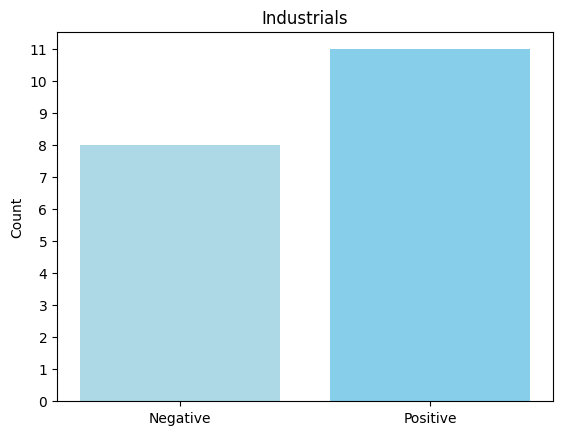

<ipython-input-21-87796b094878>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bin'] = pd.cut(df['Coef'], bins=bins, labels=labels, right=False)


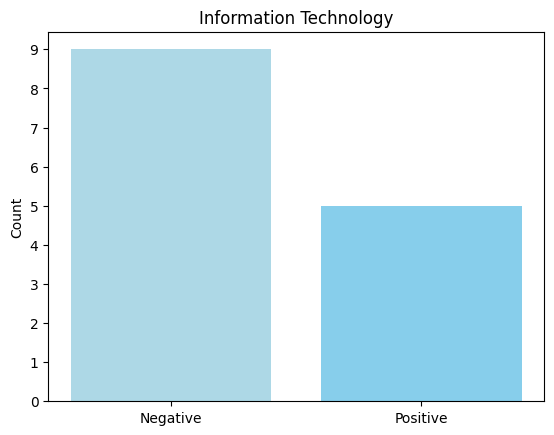

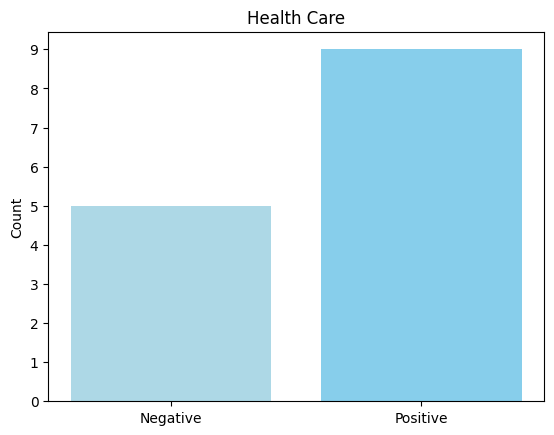

In [ ]:
nlp = 'tb' #tb: twitterbert, cb: climatebert
bins = bins = [-100000000, 0, 1000000000]
labels = ['Negative','Positive']
for sec in ['Industrials', 'Information Technology', 'Health Care']:
  res = avgSignStats[nlp][sec]
  res['Bin'] = pd.cut(res['Coef'], bins=bins, labels=labels, right=False)

  plotCoefficientCounts(res[res['R-squared']>0.1], sec)


In [ ]:
signCompsCounts = {}
for p, stats in provCols.items():
  allComps = regDfCtl[p]['tb']['linear']
  signCompsCounts[p] = []
  for s in stats:
    signCompsCounts[p].append( getSignificantCompanies(allComps, s, '%s_Pval'%s, 0.1, 'sentimentGen', False, True).groupby('Sector').count()[s+'_coef'].to_dict() )


In [ ]:
signComps = {}
for p, stats in provCols.items():
  allComps = regDfCtl[p]['tb']['linear']
  signComps[p] = {}
  for s in stats:
    signComps[p][s] =  getSignificantCompanies(allComps, s, '%s_Pval'%s, 0.1, 'sentimentGen', False, True).groupby('Sector').mean()

In [ ]:
for p in provCols['rrating']:
  df = signComps['rrating'][p]
  df.columns = ['Coef', 'R-Squared', 'P-Value']
  print(df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &                   Coef &  R-Squared &  P-Value \\
Sector      &                        &            &          \\
\midrule
Financials  &               16.89729 &    1.00000 &  0.00000 \\
Industrials & -112574371140758.73438 &    0.93736 &  0.03153 \\
\bottomrule
\end{tabular}



<ipython-input-99-189582c11f96>:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


#Plot significant companies' industries

In [ ]:
sectors = pd.read_csv('./sp500Sectors (1).csv').drop(columns = ['Name','SectoID'])
blue_shades_hex = [
    "#00008B",  # Deep Blue
    "#1E90FF",  # Dodger Blue
    "#4682B4",  # Steel Blue
    "#4169E1",  # Royal Blue
    "#7B68EE",  # Medium Slate Blue
    "#6495ED",  # Cornflower Blue
    "#87CEEB",  # Sky Blue
    "#87CEFA",  # Light Sky Blue
    "#89CFF0",  # Baby Blue
    "#B0E0E6",  # Powder Blue
    "#483D8B"   # Alice Blue
]
label_colours = {}

for i, sec in enumerate(sectors.Sector.unique().tolist()):
  label_colours[sec] = blue_shades_hex[i]



plotLabels = {'current_rriDiff' : u'Δ RRI',
            'ratingchange': u'Δ RRRating',
            'SocialDiff': u'Δ Social',
            'GovDiff': u'Δ Governance',
            'EnvDiff': u'Δ Environmental',
            'ESGDiff': u'Δ ESG',
            'ESG Score': u'Δ ESG',
            'ESG Controversies Score': u'Δ ESG Controversies',
            'ESG Combined Score': u'Δ ESG Combined',
            'Environmental Pillar Score': u'Δ Environmental',
            'Social Pillar Score': u'Δ Social',
            'Governance Pillar Score': u'Δ Governance'
            }


def plotSignificance(regDfCtl, provider, subSize, legDist, pval = 0.3, plotSize = (8,8), pltLabels = plotLabels, nlp = 'tb'):
  if nlp == 'tb':
    sentType = 'sentimentGen'

  else:
    sentType = 'sentiment'

  allComps = regDfCtl[provider][nlp]['linear']

  totalComps = len(allComps.index.get_level_values('Company').unique().tolist())

  signComps = {}
  for stats in provCols[provider]:
    signComps[stats] = getSignificantCompanies(allComps, stats, '%s_Pval'%stats, pval, sentType, False, False)

  fig = plt.figure(figsize=plotSize)
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i, stat in enumerate(provCols[provider]):
    ax = fig.add_subplot(subSize[0],subSize[1], i + 1)
    sns.countplot(x = 'Sector', data = signComps[stat], palette = label_colours, hue_order=label_colours.keys(), ax = ax)

    proportionOfSignComps = np.round((len(signComps[stat])/totalComps)*100,1)

    ax.set_title(f'{pltLabels[stat]}', fontsize = 12)  # Add a title to each subplot
    #plt.xticks(rotation=90)

    ax.set_xticklabels([])  # Remove x-axis labels
    ax.set_xlabel('%s'%(proportionOfSignComps) + '% of total')  # Remove x-axis label
    ax.set_ylabel('Frequency')
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))



  # Create legend handles and labels
  legend_handles = [mpatches.Patch(color=color, label=label) for label, color in label_colours.items()]

  # Create a legend from the handles and labels
  legend = fig.legend(handles=legend_handles, title='Industry Legend', loc='center right', bbox_to_anchor=(legDist, 0.5), fontsize = 8)

  # Customize the legend title and labels
  legend.get_title().set_fontsize('10')

  plt.show()

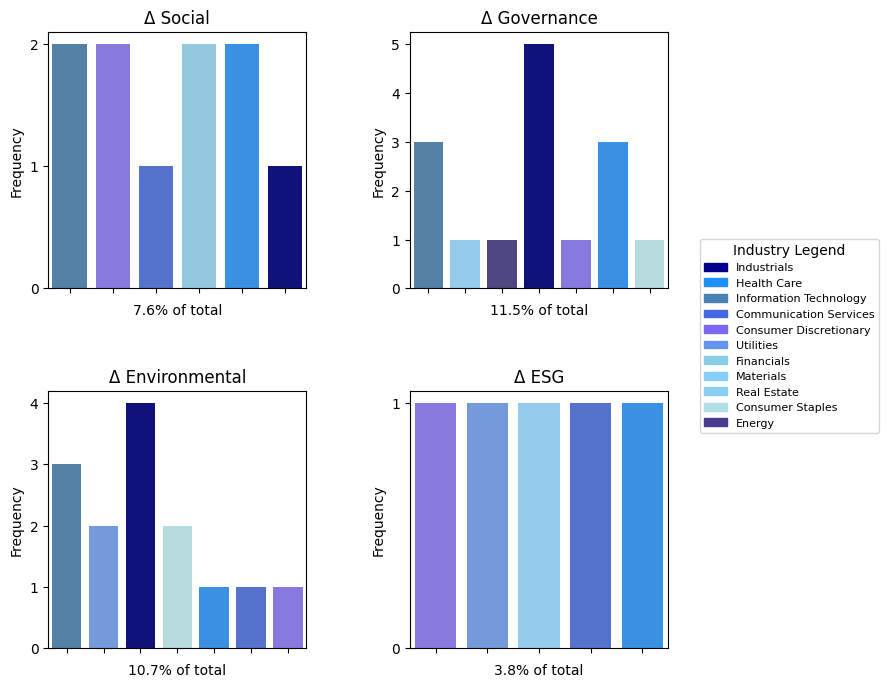

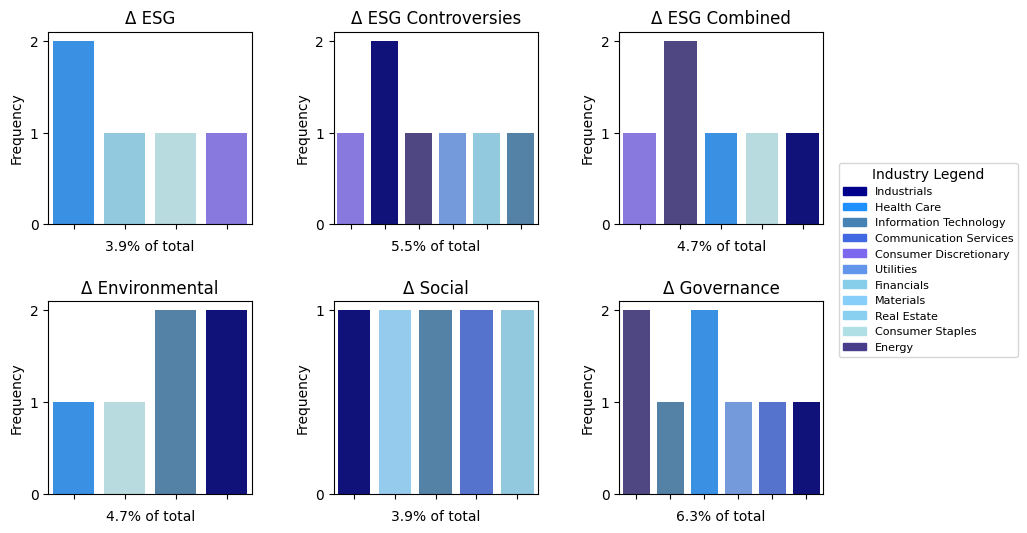

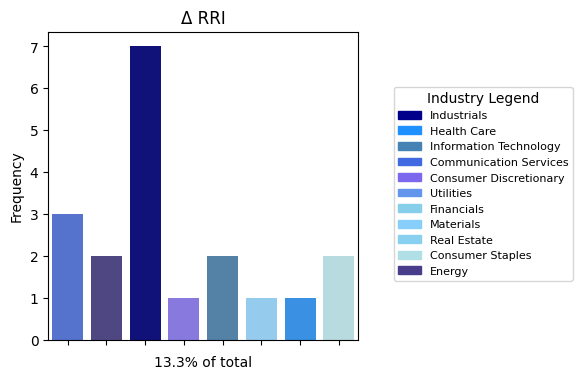

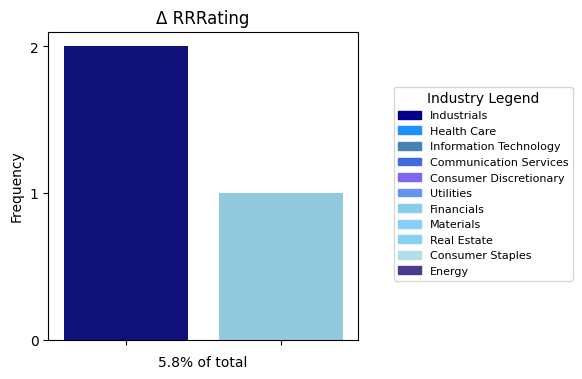

In [ ]:
provSizes = {'bbg':[2,2], 'refi':[2,3], 'rri':[1,1], 'rrating':[1,1]}
plotSizes = {'bbg':(8,8), 'refi':(10,6), 'rri':(4,4), 'rrating':(4,4)}
legendDist = {'bbg':1.17, 'refi':1.1, 'rri':1.45, 'rrating':1.45}
for p, s in provSizes.items():
  plotSignificance(regDfCtl,p ,s, legendDist[p],0.1,plotSizes[p], nlp = 'tb')

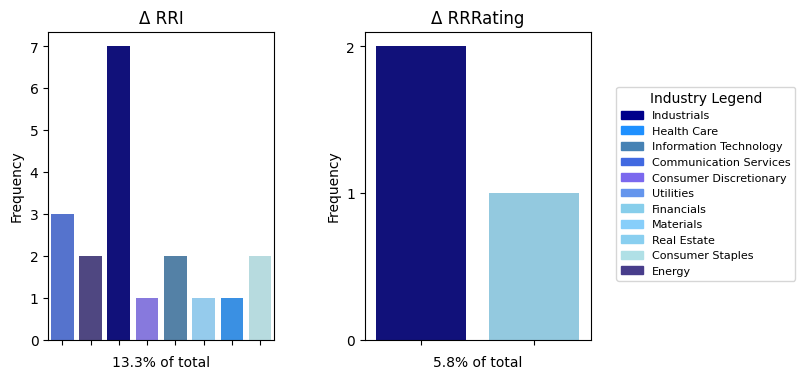

In [ ]:
allComps = [regDfCtl['rri']['tb']['linear'], regDfCtl['rrating']['tb']['linear']]

totalComps = [len(allComps[0].index.get_level_values('Company').unique().tolist()), len(allComps[1].index.get_level_values('Company').unique().tolist())]

signComps = {}

for i, stats in enumerate(['current_rriDiff', 'ratingchange']):
  signComps[stats] = getSignificantCompanies(allComps[i], stats, '%s_Pval'%stats, 0.1, 'sentimentGen', False)

fig = plt.figure(figsize=(7,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, stat in enumerate(['current_rriDiff', 'ratingchange']):
  ax = fig.add_subplot(1,2, i + 1)
  sns.countplot(x = 'Sector', data = signComps[stat], palette = label_colours, hue_order=label_colours.keys(), ax = ax)

  proportionOfSignComps = np.round((len(signComps[stat])/totalComps[i])*100,1)

  ax.set_title(f'{plotLabels[stat]}', fontsize = 12)  # Add a title to each subplot
  #plt.xticks(rotation=90)

  ax.set_xticklabels([])  # Remove x-axis labels
  ax.set_xlabel('%s'%(proportionOfSignComps) + '% of total')  # Remove x-axis label
  ax.set_ylabel('Frequency')
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))



# Create legend handles and labels
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in label_colours.items()]

# Create a legend from the handles and labels
legend = fig.legend(handles=legend_handles, title='Industry Legend', loc='center right', bbox_to_anchor=(1.2, 0.5), fontsize = 8)

# Customize the legend title and labels
legend.get_title().set_fontsize('10')

plt.show()

#Get Regression over all companies with controls

Plot sentiments and rating changes

In [ ]:
def plotRelations(df, legLoc = 'upper right'):
  cs = ['#007acc',  '#99ffcc', '#66ccff', '#b3ffcc', '#99ddff', '#b3e0ff', '#cce5ff', '#ccffcc', '#e6ffcc','#33adff','#f0ffcc']

  cols = [col for col in df.columns if col not in ['index',	'bm',	'pe_exi',	'roa'	,'debt_assets'	,'curr_ratio',	'MKTC'] and 'sentiment' not in col]

  fig, ax1 = plt.subplots(figsize=(10, 6))

  for i, c in enumerate(cols):

    ax1.plot(df.index, df[c], label=c, linewidth = 1, color = cs[i])
    ax1.set_xlim(df.index.min(), df.index.max())
    ax1.set_xlabel('Dates')
    ax1.set_ylabel('ESG data')
    ax1.tick_params(axis='y')
  #plt.legend()

  ax2 = ax1.twinx()
  ax2.plot(df.index, df['sentiment'], label='ClimateBERT', linewidth = 1, color =  'pink')
  ax2.plot(df.index, df['sentimentGen'], label='TwitterBERT', linewidth = 1, color =  'purple')
  ax2.set_ylabel('sentiment')
  ax2.tick_params(axis='y')


  # Add a legend
  lines, labels = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=legLoc)

  # Display the plot
  plt.tight_layout()
  plt.show()


def strippedResults(df, sentType, provCol):
  res = pd.DataFrame(df.loc[sentType,:].values.reshape((len(provCol),3)), columns = ['Coef', 'R-squared', 'P-value'], index = provCol)
  return np.round(res,2)

In [ ]:
comp = pd.read_csv('./aggregatedForAllControls_RepRiskRRI.csv')
comp['Unnamed: 0'] = pd.to_datetime(comp['Unnamed: 0'])

comp1 = pd.read_csv('./aggregatedForAllControls_RepRiskRating.csv')
comp1['Unnamed: 0'] = pd.to_datetime(comp1['Unnamed: 0'])

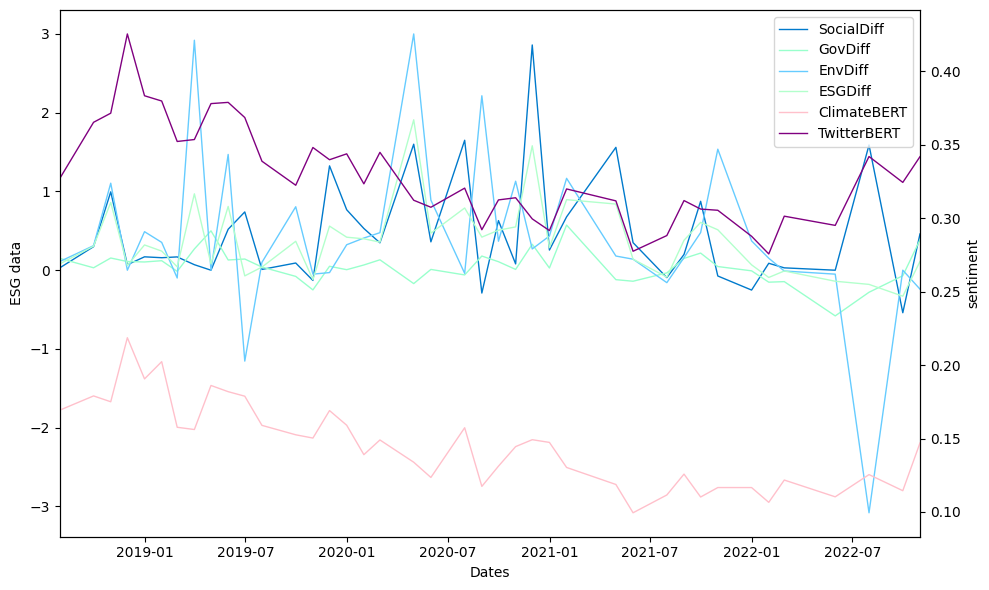

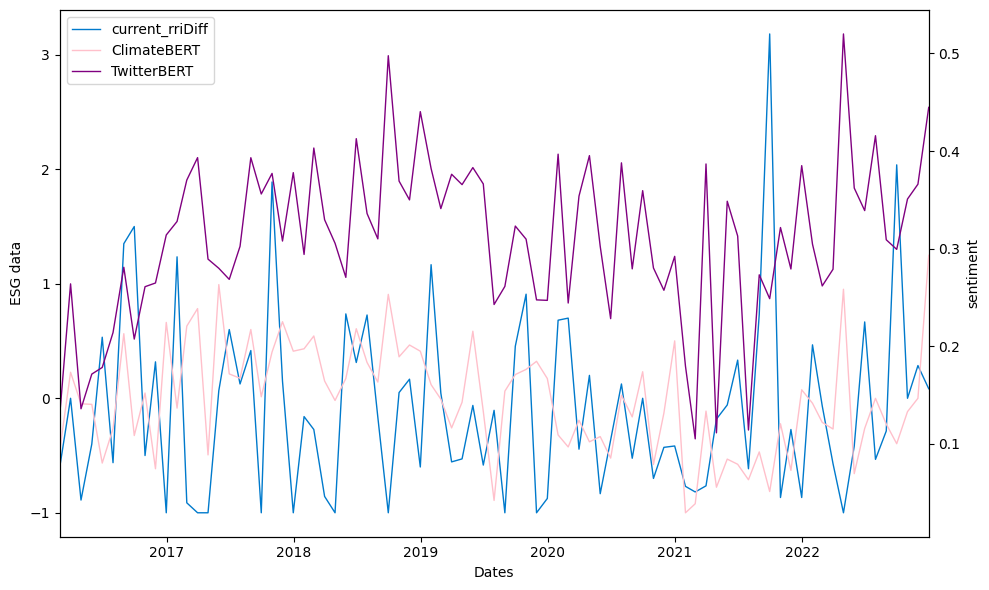

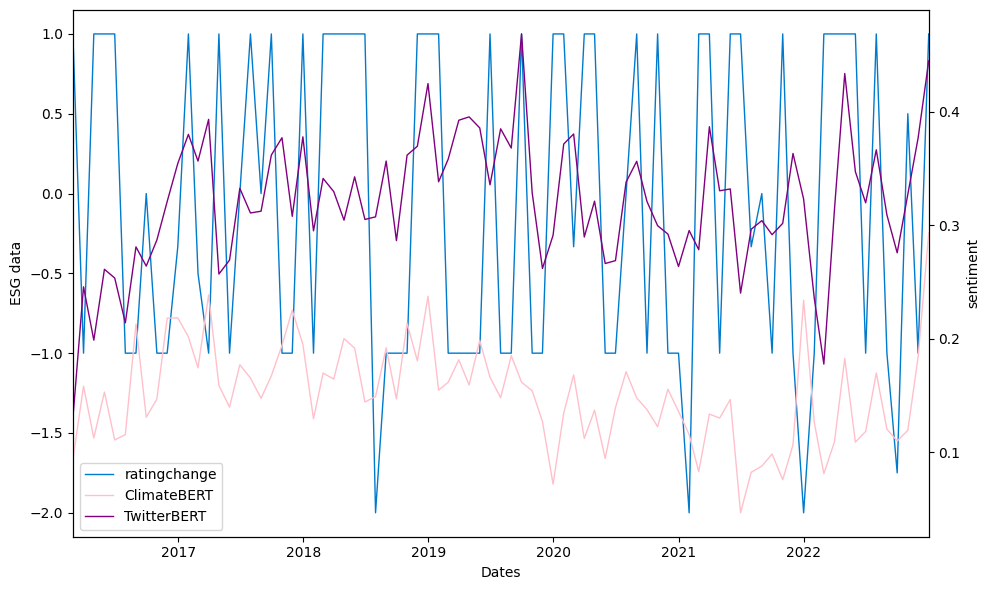

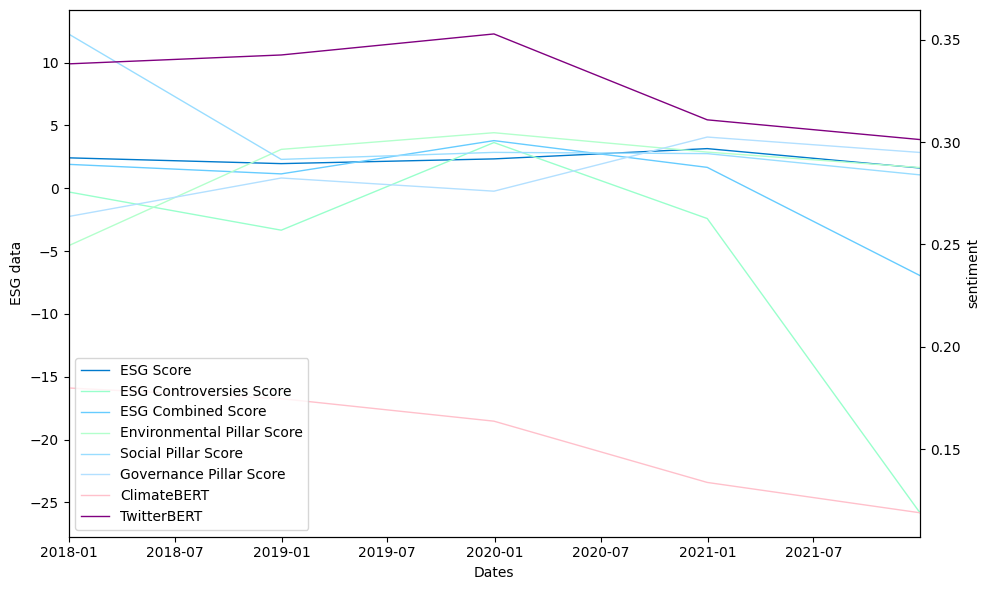

In [ ]:
provFile = {'esg':'upper right','RepRiskRRI': 'upper left','RepRiskRating': 'lower left', 'esgRefinitiv': 'lower left'}

for p, loc in provFile.items():
  comp = pd.read_csv('./aggregatedForAllControls_%s.csv'%p)
  comp['Unnamed: 0'] = pd.to_datetime(comp['Unnamed: 0'])
  df = comp.set_index('Unnamed: 0').resample('M').last().dropna()
  plotRelations(df, loc)

In [ ]:
results = {}
controlNames = ['bm', 'pe_exi','roa'	,'debt_assets'	,'curr_ratio', 'MKTC']
esgDictList = {'bbg':bbgCmp,'rri': rriCmp, 'rrating':ratCmp, 'refi':refCmp}
empties = {'bbg':bbgEmpty, 'rri':rriEmpty, 'rrating':rriEmpty, 'refi':refEmpty}

provFile = {'bbg':'esg','rri':'RepRiskRRI','rrating':'RepRiskRating', 'refi':'esgRefinitiv'}
metrics = getRegressionMetrics()
provCols = {'rri':['current_rriDiff'], 'rrating':['ratingchange'],'bbg':['SocialDiff',	'GovDiff',	'EnvDiff',	'ESGDiff'],'refi':['ESG Score',	'ESG Controversies Score',	'ESG Combined Score',	'Environmental Pillar Score','Social Pillar Score',	'Governance Pillar Score']}

for n, p in provFile.items():
  provider = n
  comp = pd.read_csv('./aggregatedForAllControls_%s.csv'%p)

  allColumns = provCols[provider]
  results[provider] = {}

  if n == 'refi':
    allCtlNames = ['roa']

  else:
    allCtlNames = controlNames
  for k, v in {'cb':'sentiment','tb':'sentimentGen'}.items():
    results[provider][k] = pd.DataFrame(columns = metrics[provider], index = [[v] + allCtlNames])

    for a in allColumns:
      coefs, r, pvals = getRegressionResultsControls( comp, a , k , allCtlNames )

      for i, stat in enumerate([v] + allCtlNames):
        results[provider][k].loc[stat,(a + '_coef',a+'_Reg', a+'_Pval')] = [coefs[i], r, pvals[i]]



In [ ]:
pd.DataFrame(np.round(np.array(results['bbg']['tb'].values, dtype = 'float64'), 2), columns = results['bbg']['tb'].columns, index = results['bbg']['cb'].index)#.to_latex()

,SocialDiff_coef,SocialDiff_Reg,SocialDiff_Pval,GovDiff_coef,GovDiff_Reg,GovDiff_Pval,EnvDiff_coef,EnvDiff_Reg,EnvDiff_Pval,ESGDiff_coef,ESGDiff_Reg,ESGDiff_Pval
sentiment,-4.20000,0.11000,0.88000,-1.12000,0.16000,0.90000,77.40000,0.18000,0.05000,27.40000,0.25000,0.16000
bm,-0.38000,0.11000,0.92000,1.78000,0.16000,0.16000,-0.10000,0.18000,0.98000,-0.04000,0.25000,0.99000
pe_exi,-0.15000,0.11000,0.96000,0.35000,0.16000,0.71000,4.00000,0.18000,0.29000,0.96000,0.25000,0.59000
roa,0.01000,0.11000,0.73000,-0.02000,0.16000,0.06000,0.01000,0.18000,0.78000,0.00000,0.25000,0.79000
debt_assets,1.50000,0.11000,0.94000,-14.66000,0.16000,0.04000,-49.12000,0.18000,0.09000,-22.26000,0.25000,0.10000
curr_ratio,35.55000,0.11000,0.43000,1.06000,0.16000,0.94000,-115.64000,0.18000,0.06000,-19.85000,0.25000,0.51000
MKTC,0.96000,0.11000,0.82000,-0.41000,0.16000,0.76000,-10.80000,0.18000,0.07000,-2.71000,0.25000,0.32000


In [ ]:
strippedResults(results['rri']['cb'], 'sentiment', provCols['rri'])#.to_latex()

,Coef,R-squared,P-value
current_rriDiff,-1.90857,0.00503,0.41438
